# Oh hey.

The main goal of this homework is to demonstrate how to use CasADi for optimal control and MPC.

https://web.casadi.org/

CasADi is a symbolic framework for automatic differentiation that is specifically designed for control applications. 



In [2]:
import numpy as np
import casadi as cdi
import scipy.integrate as itg
import matplotlib.pyplot as plt
%matplotlib inline

# Simulations with CasADi

The code below demonstrates simulation of pendulum on a cart system. This is a classical benchmark problem from controls. There is pendulum attached to a cart, and the goal is to swing the system from a "down" position to an "up" position and balance it there. 

We will model the system via CasADi symbolics, and then simulate it both via `scipy`, and via `CasADi`.

The dynamics are taken from here:

Lozano, Rogelio, and Isabelle Fantoni. "Passivity based control of the inverted pendulum." Perspectives in control. Springer, London, 1998. 83-95.

A pdf of this paper is on the canvas. Later, we will also utilize a version of their swing-up controller.



Text(0.5, 1.0, 'CasADi Simulation')

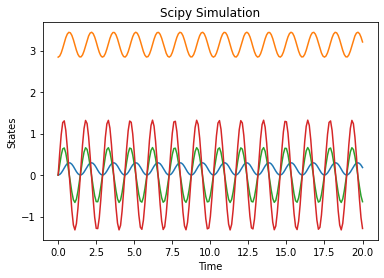

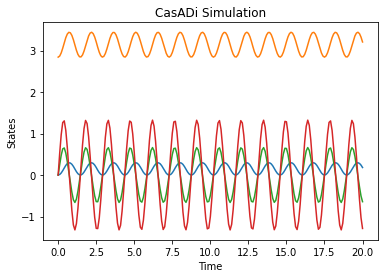

In [15]:
# Dynamics of the pendulum on a cart system

#### Parameters ####
M = 1.
m = 1.
ell = 1.
g = 9.8

#### State #####
X = cdi.SX.sym('X',4)

p = X[0]
theta = X[1]
v = X[2]
omega = X[3]


#### Input #####
U = cdi.SX.sym('U')

#### Dynamics ####
det = m*ell**2 * (M+m*cdi.sin(theta)**2)

v_dot = (m**2 * ell** 3 * omega**2 * cdi.sin(theta) - \
         m**2 * ell**2 * g * cdi.sin(theta) * cdi.cos(theta) + \
         m * ell**2 * U) / det

omega_dot = (-m**2 * ell**2 * omega**2 *cdi.sin(theta)*cdi.cos(theta) + \
            (M+m)*m*g*ell*cdi.sin(theta) - m*ell * cdi.cos(theta) * U) / det

X_dot = cdi.vcat([v,omega,v_dot,omega_dot])

##### Integration Via Scipy #####
vectorFieldFun = cdi.Function('f',[X,U],[X_dot])

def openLoopVF_fun(x,t):
    x_dot = vectorFieldFun(x,np.array([0.]))
    
    # Finally we must cast it as a numpy array
    return np.array(x_dot).squeeze()

LongTime = np.linspace(0,20,201)
# Starting nearly down.
x0 = np.array([0,np.pi-.3,0.,0])
X_scipy = itg.odeint(openLoopVF_fun,x0,LongTime)
plt.plot(LongTime,X_scipy)
plt.xlabel('Time')
plt.ylabel('States')
plt.title('Scipy Simulation')

#### Casadi Simulation ##### 

# Simulate this in CasADi
openLoopVF = vectorFieldFun(X,0)

dt = LongTime[1] - LongTime[0]
ode = {'x' : X, 'ode' : openLoopVF}
opts = {'tf' : dt}
Sim = cdi.integrator('Sim','cvodes',ode,opts)

x = cdi.DM(x0)

X_cdi = [x]

for step in LongTime[:-1]:
    x = Sim(x0=x)['xf']
    X_cdi.append(x)
    
X_cdi = cdi.hcat(X_cdi).T
plt.figure()
plt.plot(LongTime,X_cdi)
plt.xlabel('Time')
plt.ylabel('States')
plt.title('CasADi Simulation')

# The Swing-Up Task

The algorithm from the paper gives a method for swinging the pendulum up based on Lyapunov arguments. However, the method swings the controller but never stabilizes it in an upright position. In the plot below, the angle of the pendulum oscillates between $0$ and $2\pi$.

Text(0.5, 0, 'Time')

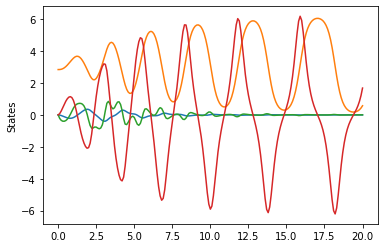

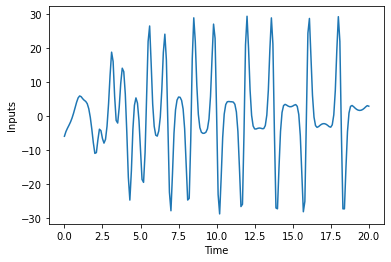

In [18]:
##### A Swing-Up Controller 

# Swing-Up controller Parameters
Kv = 4 * m * g * ell + .1
#Kv = 10
Kx = .01
Kdec = 100.
    
q_dot = X[2:]
    
    
Mass = cdi.vcat([cdi.hcat([M+m,m*ell*cdi.cos(theta)]),
                 cdi.hcat([m*ell*cdi.cos(theta),m*ell**2])])
    
KE = .5 * q_dot.T @ Mass @ q_dot
PE = m*g*ell * (cdi.cos(theta)-1)
E = KE + PE
    
scaledDet = (M+m*cdi.sin(theta)**2)
den = E + Kv / scaledDet
    
num = -Kdec * v - Kx * p + \
      (g*cdi.cos(theta) - ell*omega**2) * \
       Kv *m*cdi.sin(theta)/scaledDet
    
U_swingUp = num/den

#### Functional Form #####
swingUpFun = cdi.Function('swingUp',[X],[U_swingUp])

##### Scipy Simulation ####
def swingUpVF(x,t):
    u  = swingUpFun(x)
    x_dot = vectorFieldFun(x,u)
    return np.array(x_dot).squeeze()

x0 = np.array([0,np.pi-.3,0.,0])
X_scipy = itg.odeint(swingUpVF,x0,LongTime)
U_scipy = np.array([swingUpFun(x) for x in X_scipy])
plt.plot(LongTime,X_scipy)
plt.ylabel('States')
plt.figure()
plt.plot(LongTime,U_scipy)
plt.ylabel('Inputs')
plt.xlabel('Time')




# Coding Question 

Simulate the swing-up system via CasADi over the `LongTime` grid. Plot the states and the inputs, similar to what was done for the scipy simulation.

In [19]:
# Put your code here

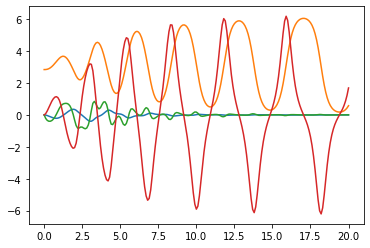

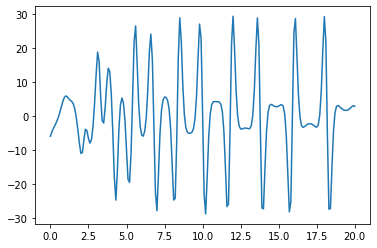

In [22]:
# Solution
swingUpCL = vectorFieldFun(X,U_swingUp)

ode = {'x' : X, 'ode' : swingUpCL}
opts = {'tf' : dt}
Sim = cdi.integrator('Sim','cvodes',ode,opts)

x = cdi.DM(x0)

X_cdi = [x]
U_cdi = [swingUpFun(x)]

for step in LongTime[:-1]:
    x = Sim(x0=x)['xf']
    u = swingUpFun(x)
    X_cdi.append(x)
    U_cdi.append(u)
    
X_cdi = cdi.hcat(X_cdi).T
U_cdi = cdi.hcat(U_cdi).T
plt.plot(LongTime,X_cdi)

plt.figure()
plt.plot(LongTime,U_cdi)

# Optimal Control with CasADi

Now we will swing the pendulum up using optimal control. The code below implements a *direct shooting* method, as discussed in the last chapter of the MPC book. Our particular problem has the form:

\begin{align*}
 & \min && \int_0^T \ell({\bf x}(t),{\bf u(t)}) dt \\
 & \textrm{subject to} && {\bf x}(t) = x \\
 &&& \dot {\bf x}(t) = f({\bf x}(t),{\bf u}(t)) \\
 &&& {\bf u}(t) \in \mathbb{U}
\end{align*}

We will step through the process of discretizing this problem to get something that we can optimize  numerically.

# Theory Question

The first thing we do is utilize a trick that enables us to discretize the cost integral and the differential equation simultaneously. 

Say that ${\bf \zeta}(0)=0$ and $\dot {\bf \zeta}(t) = \ell({\bf x}(t),{\bf u}(t))$. Explain why minimizing ${\bf \zeta}(T)$ is the same as minimizing the original cost.

Just write your answer here. There is barely any math to do on this one.

# Discretizing the Augmented System

Now let ${\bf y}(t) = \begin{bmatrix} {\bf \zeta}(t) \\ {\bf x}(t) \end{bmatrix}$ and let  
\begin{equation*}
 \dot {\bf y}(t) = \begin{bmatrix}
     \ell({\bf x}(t),{\bf u}(t)) \\
     f({\bf x}(t),{\bf u}(t)) 
 \end{bmatrix}
 =: F({\bf y}(t),{\bf u}(t))
\end{equation*} 

In the simulations above, we sampled the dynamics with period $dt=0.1$. The direct shooting approach 
* Holds the inputs ${\bf u}(t)$ fixed for $t\in [i dt,(i+1)dt)$ for integers $i$
* Simulates over a sampling period with this fixed input: ${\bf y}((k+1)dt) = \Phi({\bf y}(kdt),{\bf u}(kdt))$. Here  $\Phi$ is a function that implements this simulation.
* Optimizes over the inputs ${\bf u}(0),{\bf u}(dt),\ldots,{\bf u}((N-1)dt)$

Code for this is given below. 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       10
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Text(0, 0.5, 'Cost')

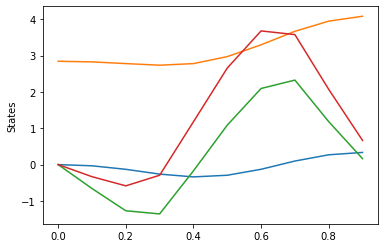

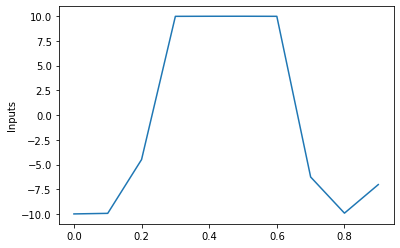

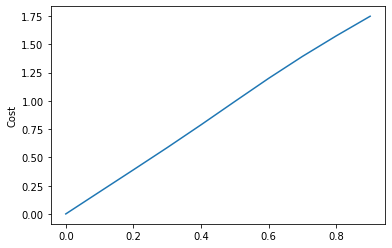

In [49]:
# This is the number of steps in the simulation
# If N >= 30, it will complete the swing up complete the swing up.
N = 10
ShortTime = dt * np.arange(N)

##### Initialize the Optimization Object ####
opti = cdi.Opti()
U_traj = opti.variable(N)
x0_param = opti.parameter(4)
opti.set_value(x0_param,x0)
# This is a parameter. Similar to cvxpy, we can change the parameter 
# and re-run the optimization. This is very useful for MPC

##### The Cost Function #####
cost = 1-cdi.cos(theta) + p**2
# The cost penalizes the deviation from vertical
# As well as the distance from 0
costFun = cdi.Function('cost',[X,U],[cost])

##### Auxiliary Dynamics ####
zeta = cdi.SX.sym('zeta')
Y = cdi.vcat([zeta,X])
Y_dot = cdi.vcat([cost,X_dot])

# Now the ODE takes U as a parameter  
# This make the simulation outputs differentiable with respect to U
ode = {'x' : Y, 'ode' : Y_dot, 'p' : U}
# If the optimization is very slow, you can switch 'cvodes' to 'rk' for quicker 
# but less accurate solutions
Sim = cdi.integrator('Sim','rk',ode,opts)

##### Build the simulation with variable inputs #####
x_prob = x0_param
y_prob = cdi.vcat([0,x_prob])
for i in range(N):
    u_prob = U_traj[i]
    y_prob = Sim(x0=y_prob,p=u_prob)['xf']

##### Set objective ######
opti.minimize(y_prob[0])
    
#### Set constraints #####    
opti.subject_to(opti.bounded(-10,U_traj,10))
# Since the cost has no dependence on U, we need to put constraints on it.
# Otherwise, the U may fly off to infinity.

### Optimize the inputs ######
#opti.set_initial(U_traj,U_cdi)
# Setting print_level to 0 suppresses most things
opti.solver('ipopt',{},{'tol' : 1e-3,'print_level' : 5})
sol = opti.solve()

### Plot the Optimal SOlution 

U_opt = sol.value(U_traj)
# Switch back to more accurate cvodes for checking
SimOpt = cdi.integrator('SimOpt','cvodes',ode,opts)

#### Simulate with the Optimal Inputs
x = cdi.DM(x0)
y = cdi.vcat([0,x])
Y_opt = [y]
for i in range(N-1):
    u = U_opt[i]
    y = SimOpt(x0 = y,p =u)['xf']
    Y_opt.append(y)
    
Y_opt = cdi.hcat(Y_opt).T
plt.plot(ShortTime,Y_opt[:,1:])
plt.ylabel('States')
plt.figure()
plt.plot(ShortTime,U_opt)
plt.ylabel('Inputs')
plt.figure()
plt.plot(ShortTime,Y_opt[:,0])
plt.ylabel('Cost')

# Coding Question

Use the direct shooting method to create an MPC method that swings the pendulum up and stabilizes it. Simulate your method over the time grid `LongTime`

Hints:

* You can use `opti` from above directly.
* Changing $N$ in the code above changes the behavior a lot:
    - Any $N\ge 10$ will likely suffice for MPC. (Though $N=10$ would not suffice to swing up the system in the code above. There just isn't enough time.)
    - As $N$ gets larger, the performance gets better, but the computations get slower.
* Warm-Starting with the initial condition: You can use `opti.set_initial` (see the documentation) to give a good starting point for the optimization. Good initialization based on the most recent solve noticeably speeds up the solution.
* The following options supress the solver messages, and get some further warm-start benefits
```
opti.solver('ipopt',{'verbose' : False,'print_time' :False},
            {'tol' : 1e-3,'print_level' : 0,'warm_start_init_point' : "yes"})
```

step 1 of 201
step 2 of 201
step 3 of 201
step 4 of 201
step 5 of 201
step 6 of 201
step 7 of 201
step 8 of 201
step 9 of 201
step 10 of 201
step 11 of 201
step 12 of 201
step 13 of 201
step 14 of 201
step 15 of 201
step 16 of 201
step 17 of 201
step 18 of 201
step 19 of 201
step 20 of 201
step 21 of 201
step 22 of 201
step 23 of 201
step 24 of 201
step 25 of 201
step 26 of 201
step 27 of 201
step 28 of 201
step 29 of 201
step 30 of 201
step 31 of 201
step 32 of 201
step 33 of 201
step 34 of 201
step 35 of 201
step 36 of 201
step 37 of 201
step 38 of 201
step 39 of 201
step 40 of 201
step 41 of 201
step 42 of 201
step 43 of 201
step 44 of 201
step 45 of 201
step 46 of 201
step 47 of 201
step 48 of 201
step 49 of 201
step 50 of 201
step 51 of 201
step 52 of 201
step 53 of 201
step 54 of 201
step 55 of 201
step 56 of 201
step 57 of 201
step 58 of 201
step 59 of 201
step 60 of 201
step 61 of 201
step 62 of 201
step 63 of 201
step 64 of 201
step 65 of 201
step 66 of 201
step 67 of 201
step

Text(0, 0.5, 'Cost')

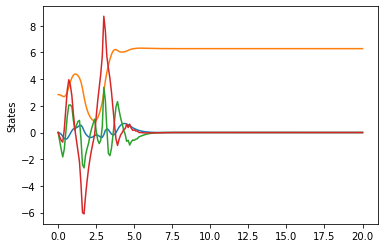

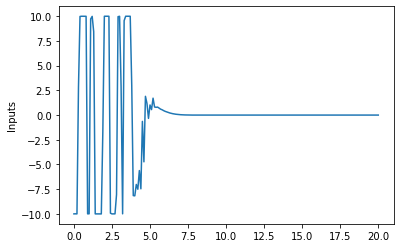

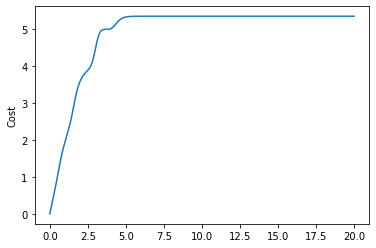

In [55]:
# Solution

NumSteps = len(LongTime)
x = cdi.DM(x0)
y = cdi.vcat([0,x])

# Setting a very loose tolerance for faster solves
opti.solver('ipopt',{'verbose' : False,'print_time' :False},
            {'tol' : 1e-3,'print_level' : 0,'warm_start_init_point' : "yes"})

SimMPC = cdi.integrator('SimMPC','cvodes',ode,opts)
Y_MPC = []
U_MPC = []

U_last = None
for step in range(NumSteps):
    print('step %d of %d' % (step+1,NumSteps))
    opti.set_value(x0_param,x)
    # Very simple warm start
    if U_last is None:
        U_init = cdi.DM.zeros(N)
    else:
        U_init = cdi.vcat([U_last[1:],0])
    opti.set_initial(U_traj,U_init)
    sol = opti.solve()
    U_last = sol.value(U_traj)
    u = U_last[0]
    
    Y_MPC.append(y)
    U_MPC.append(u)
    y = SimMPC(x0=y,p=u)['xf']
    x = y[1:]
    
Y_MPC = cdi.hcat(Y_MPC).T
U_MPC = cdi.hcat(U_MPC).T

#plt.plot(CoarseTime,U_opt)

plt.figure()

plt.plot(LongTime,Y_MPC[:,1:])
plt.ylabel('States')
plt.figure()
plt.plot(LongTime,U_MPC)
plt.ylabel('Inputs')
plt.figure()
plt.plot(LongTime,Y_MPC[:,0])
plt.ylabel('Cost')